# Modeling and Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('cleaned_data.csv')
df = df.drop(columns='Unnamed: 0')
df.head()

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_delivery,saw_account_upgrade,saw_homepage,returning_user,ordered
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1


In [3]:
X = df.drop(['ordered'], axis=1) 
y = df['ordered'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Split the data into training and testing set. Perform undersampling only on the training set.

In [4]:
y_train.value_counts()

ordered
0    349013
1     15307
Name: count, dtype: int64

### KFold And Undersampling Function

In [5]:
def score_model(model, X_train, y_train, params=None, cv=None):
    """
    Creates folds manually, and undersamples within each fold.
    Returns an array of recall scores.
    """
    if cv is None:
        cv = KFold(n_splits=5, shuffle=True, random_state=42)
   
    recall_scores = []

    for train_fold_index, val_fold_index in cv.split(X_train, y_train):

        # the training data
        X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train.iloc[train_fold_index]

        # the validation data
        X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train.iloc[val_fold_index]
        
        class_count = np.count_nonzero(y_train_fold == 1) 
        sampling_strategy = {0:class_count, 1:class_count}
        rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    
        # Undersample only the data in the training section
        X_train_fold_undersample, y_train_fold_undersample = rus.fit_resample(X_train_fold, y_train_fold)
                
        # Fit the model on the undersampled training data
        model_obj = model(**params).fit(X_train_fold_undersample, y_train_fold_undersample)
        
        # Score the model on the validation data (non-undersampled)
        pred = model_obj.predict(X_val_fold)        
        rc_score = recall_score(y_val_fold, pred)
        
        recall_scores.append(rc_score)
        
    return np.array(recall_scores)

We want to return the recall score because this is the most important metric for our business problem.

### Hyper-Parameterization Function

In [6]:
def param_optimizer(model, params, X_train, y_train):
    """
    Performs hyper-parameterization for our models.
    Tests a set of parameters and returns the ones that
    provide the best recall score.
    """
    score_tracker = []
    for p1 in params['p1']:
        for p2 in params['p2']:

            # check for which model the parameters are for
            if model == RandomForestClassifier:
                _params = {
                    'n_estimators': p1,
                    'max_depth': p2,
                    'random_state': 13
                }
            elif model == AdaBoostClassifier:
                _params = {
                    'n_estimators': p1,
                    'learning_rate': p2,
                    'random_state': 13
                }
            elif model == BernoulliNB:
                _params = {
                    'alpha': p1,
                    'fit_prior': p2
                }

            # stores the average recall score, after cross-validation, for each parameter
            _params['recall'] = score_model(model, X_train, y_train, _params).mean()
            score_tracker.append(_params)
    
    # Return the best parameters
    return sorted(score_tracker, key=lambda x: x['recall'], reverse=True)[0]


With these functions, we will now be able to find the ideal parameters for each of our models to get the best recall scores.

### RandomForest Hyper-Parameterization

In [7]:
# This cell will take about a minute to finish running
rf_params = {
    'p1': [50, 100, 200],
    'p2': [4, 6, 10, 12],
}

param_optimizer(RandomForestClassifier, rf_params, X_train, y_train)

# This output shows the best parameters to use 
# to get the highest recall score

{'n_estimators': 50,
 'max_depth': 4,
 'random_state': 13,
 'recall': 0.9953737536228319}

### AdaBoost Hyper-Parameterization

In [8]:
# This cell will take about a minute to finish running
adaboost_params = {
    'p1': [50, 100, 200],
    'p2': [0.25, 0.5, 1.0, 2],
}

param_optimizer(AdaBoostClassifier, adaboost_params, X_train, y_train)

# This output shows the best parameters to use 
# to get the highest recall score

{'n_estimators': 50,
 'learning_rate': 1.0,
 'random_state': 13,
 'recall': 0.990598236061787}

### Naive Bayes Hyper-Parameterization

In [9]:
# This cell will take about a minute to finish running
nb_params = {
    'p1': [0.001, 0.05, 0.1, 0.5, 1],
    'p2': [True, False]
}

param_optimizer(BernoulliNB, nb_params, X_train, y_train)

# This output shows the best parameters to use 
# to get the highest recall score

{'alpha': 0.001, 'fit_prior': True, 'recall': 0.9956377373076993}

### Logistic Regression

Logistic Regression doesn't not need hyper-parameterization.

# Evaluations

## Testing on original dataset

Using the parameters we found, we will test our models on the untouched testing data.

In [10]:
#Undersample training set
class_count = np.count_nonzero(y_train == 1) 
sampling_strategy = {0:class_count, 1:class_count}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)

X_train_undersample, y_train_undersample = rus.fit_resample(X_train, y_train)

# Function to train and evaluate models on the test set
def test_eval(model):
    model.fit(X_train_undersample, y_train_undersample)

    pred = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    recall = recall_score(y_test, pred)
    roc = roc_auc_score(y_test, pred_proba)
    cm = confusion_matrix(y_test, pred)

    print(f'RANDOMFOREST SCORES:\n'
        f'\tAccuracy: {acc:0.4f}\n'
        f'\tF-1: {f1:0.4f}\n'
        f'\tRecall: {recall:0.4f}\n'
        f'\tRoc: {roc:0.4f}\n')

    ConfusionMatrixDisplay.from_predictions(y_test, pred, display_labels=model.classes_, 
                                                   colorbar=False, cmap='Blues')
    

### RandomForest

RANDOMFOREST SCORES:
	Accuracy: 0.9871
	F-1: 0.8653
	Recall: 0.9937
	Roc: 0.9971



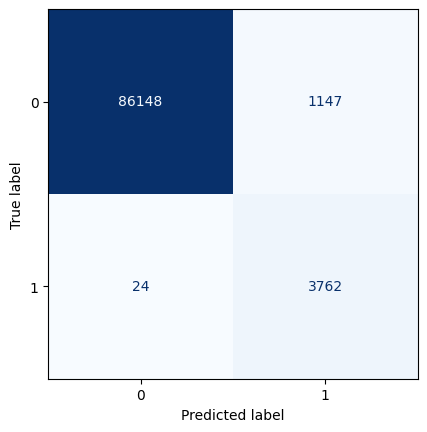

In [11]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 4, random_state = 13)

test_eval(rf)

### AdaBoost

RANDOMFOREST SCORES:
	Accuracy: 0.9929
	F-1: 0.9206
	Recall: 0.9897
	Roc: 0.9972



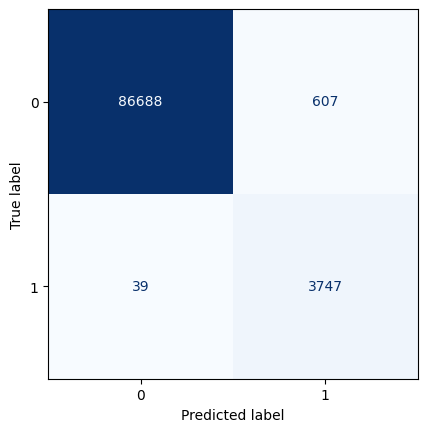

In [12]:
ada = AdaBoostClassifier(n_estimators = 50, learning_rate = 1, random_state = 13)

test_eval(ada)

### LogisticRegression

RANDOMFOREST SCORES:
	Accuracy: 0.9921
	F-1: 0.9123
	Recall: 0.9902
	Roc: 0.9973



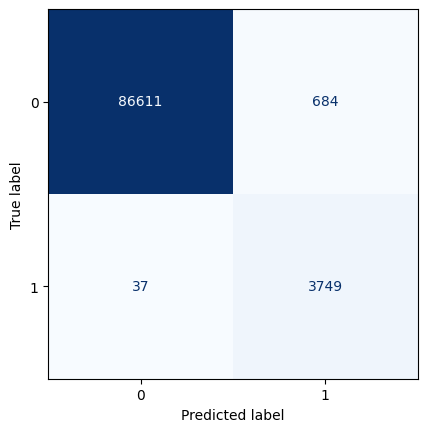

In [15]:
lr = LogisticRegression()

test_eval(lr)

RANDOMFOREST SCORES:
	Accuracy: 0.9732
	F-1: 0.7553
	Recall: 0.9966
	Roc: 0.9963



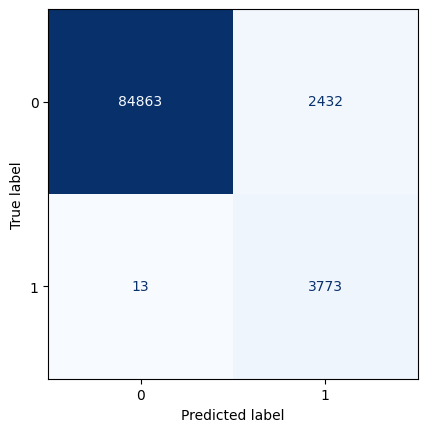

In [14]:
nb = BernoulliNB(alpha=0.001)

test_eval(nb)

Naive Bayes performed the best with a recall score of 99.63%, only 13 false negatives. This will be the model we decide to deploy.